<h1 align='center'><b>Введение в нейронные сети<b></h1>

<h2 align='center'>Урок 8. GAN</h2>

<h3 align='left'>Практическое задание:</h3>  

Попробуйте улучшить работу нейронной сети рассмотренной в методическом пособии. <br>
Приложите анализ. <br>
Приложете лучшее сгенерированное изображение к уроку. <br>
Обратите внимание для запуска нейронной сети понадобиться tensorflow 2.1.0 и минимум 8gb опер. памяти(если запускать на процессоре).

**Подключение необходимых библиотек**

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

**Предварительная обработка данных**

Нам необходимо конвертировать изображения в `286 x 286` и случайно выбранные из них обрезать до `256 x 256`. Кроме этого мы перевернем изображения горизонтально, т.е. слева на право. Таким образом мы проведем процедуру похожую на image augmentation.

In [ ]:
dataset = tfds.load('cycle_gan/horse2zebra', as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3]
    )
    return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [ ]:
train_horses = train_horses.map(preprocess_image_train) \
                           .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(preprocess_image_train)\
                           .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(preprocess_image_test)\
                         .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(preprocess_image_test)\
                         .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

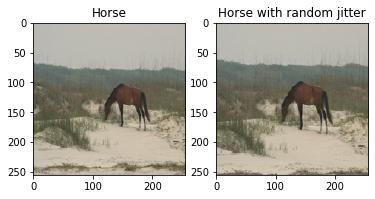

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5);

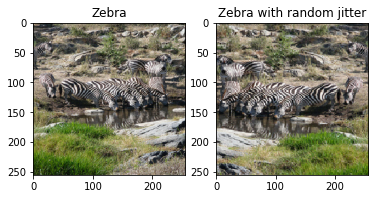

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5);

**Импортирование  Pix2Pix модели**

Генератор и дискриминатор мы возьмем из Pix2Pix модели, генерация будет осуществляться с применением Unet.

In [ ]:
OUTPUT_CHANNELS = 3

generator_to_zebra = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_to_horse = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_horse = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_zebra = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
generator_to_zebra.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_14[0][0]']               
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                        

In [ ]:
discriminator_horse.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    3072      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_37 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

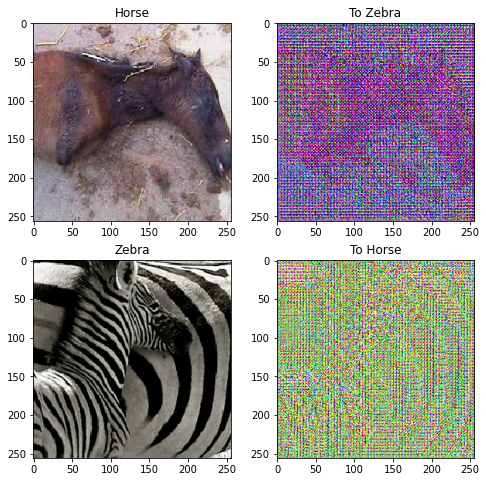

In [ ]:
to_zebra = generator_to_zebra(sample_horse)
to_horse = generator_to_horse(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

**Loss functions**

Loss функции для генератора и дискриминатора можно взять также из [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * loss

Инициализация оптимайзеров для всех генераторов и всех дискриминаторов.

In [ ]:
generator_to_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_to_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**Checkpoints**

Сохранение промежуточных результатов, для того, чтобы при необходимости можно было продолжить обучение, а не начинать сначала.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    generator_g=generator_to_zebra,
    generator_f=generator_to_horse,
    discriminator_x=discriminator_horse,
    discriminator_y=discriminator_zebra,
    generator_g_optimizer=generator_to_zebra_optimizer,
    generator_f_optimizer=generator_to_horse_optimizer,
    discriminator_x_optimizer=discriminator_horse_optimizer,
    discriminator_y_optimizer=discriminator_zebra_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

**Training**

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
        
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])

        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Несмотря на то, что тренировочный процесс у GAN более сложный, он состоит из тех же этапов, что обычно:

* Получить предсказание
* Вычислить ошибку
* Посчитать градиенты используя обратное распространения ошибки.
* Применить градиенты для оптимайзера.

In [ ]:
def train_step(real_horse, real_zebra):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        
        fake_zebra = generator_to_zebra(real_horse, training=True)
        cycled_horse = generator_to_horse(fake_zebra, training=True)

        fake_horse = generator_to_horse(real_zebra, training=True)
        cycled_zebra = generator_to_zebra(fake_horse, training=True)

        # same_horse and same_zebra are used for identity loss.
        same_horse = generator_to_horse(real_horse, training=True)
        same_zebra = generator_to_zebra(real_zebra, training=True)

        disc_real_horse = discriminator_horse(real_horse, training=True)
        disc_real_zebra = discriminator_zebra(real_zebra, training=True)

        disc_fake_horse = discriminator_horse(fake_horse, training=True)
        disc_fake_zebra = discriminator_zebra(fake_zebra, training=True)

        # calculate the loss
        gen_to_zebra_loss = generator_loss(disc_fake_zebra)
        gen_to_horse_loss = generator_loss(disc_fake_horse)
        
        total_cycle_loss = calc_cycle_loss(real_horse, cycled_horse) \
                           + calc_cycle_loss(real_zebra, cycled_zebra)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_to_zebra_loss = gen_to_zebra_loss + \
                                  total_cycle_loss + \
                                  identity_loss(real_zebra, same_zebra)
        total_gen_to_horse_loss = gen_to_horse_loss + \
                                  total_cycle_loss + \
                                  identity_loss(real_horse, same_horse)

        disc_horse_loss = discriminator_loss(disc_real_horse, disc_fake_horse)
        disc_zebra_loss = discriminator_loss(disc_real_zebra, disc_fake_zebra)
    
    # Calculate the gradients for generator and discriminator
    generator_to_zebra_gradients = tape.gradient(
        total_gen_to_zebra_loss,
        generator_to_zebra.trainable_variables
    )
    generator_to_horse_gradients = tape.gradient(
        total_gen_to_horse_loss,
        generator_to_horse.trainable_variables
    )
    
    discriminator_horse_gradients = tape.gradient(
        disc_horse_loss, 
        discriminator_horse.trainable_variables
    )
    discriminator_zebra_gradients = tape.gradient(
        disc_zebra_loss,
        discriminator_zebra.trainable_variables
    )
    
    # Apply the gradients to the optimizer
    generator_to_zebra_optimizer.apply_gradients(
        zip(generator_to_zebra_gradients,
            generator_to_zebra.trainable_variables)
    )

    generator_to_horse_optimizer.apply_gradients(
        zip(generator_to_horse_gradients,
            generator_to_horse.trainable_variables)
    )
    
    discriminator_horse_optimizer.apply_gradients(
        zip(discriminator_horse_gradients,
            discriminator_horse.trainable_variables)
    )
    
    discriminator_zebra_optimizer.apply_gradients(
        zip(discriminator_zebra_gradients,
            discriminator_zebra.trainable_variables)
    )

In [ ]:
EPOCHS = 20

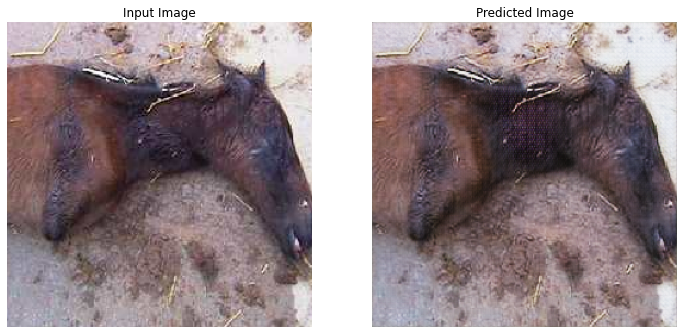

Saving checkpoint for epoch 20 at ./checkpoints/train/ckpt-4
Time taken for epoch 20 is 345.46995663642883 sec



In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_horse, image_zebra in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_horse, image_zebra)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_to_zebra, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Time taken for epoch {epoch + 1} is {time.time()-start} sec\n')

**Генерация из тестового датасета**

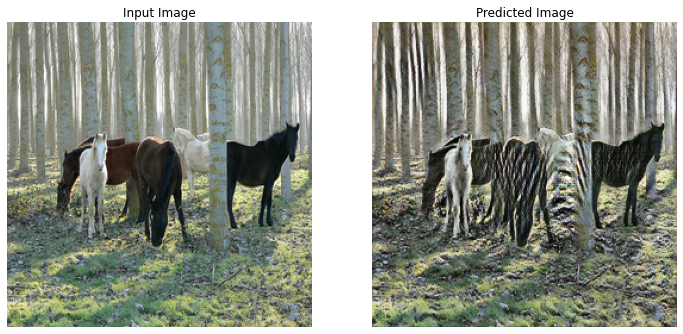

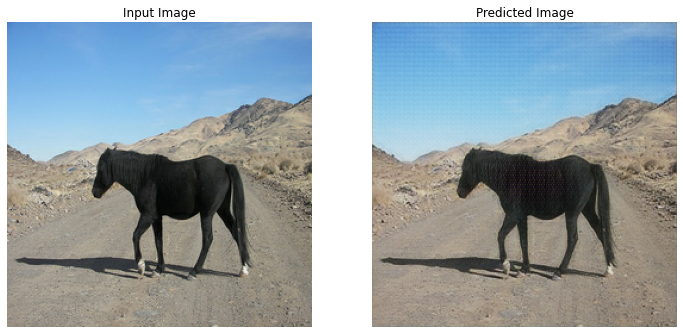

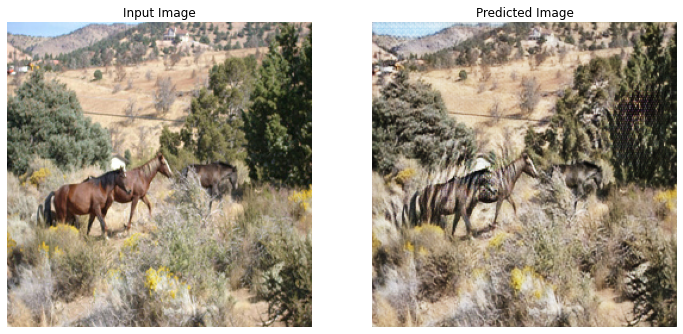

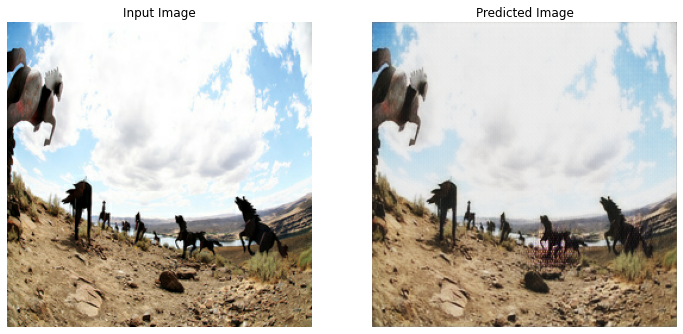

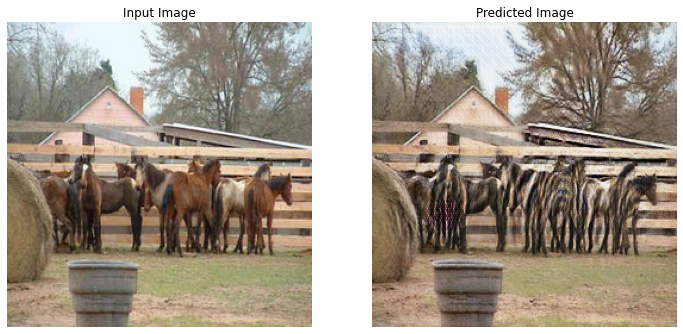

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
    generate_images(generator_to_zebra, inp)

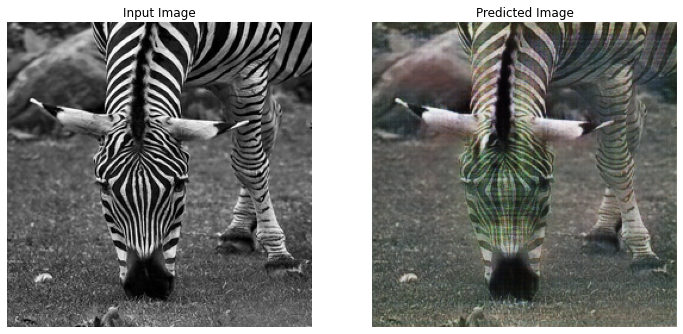

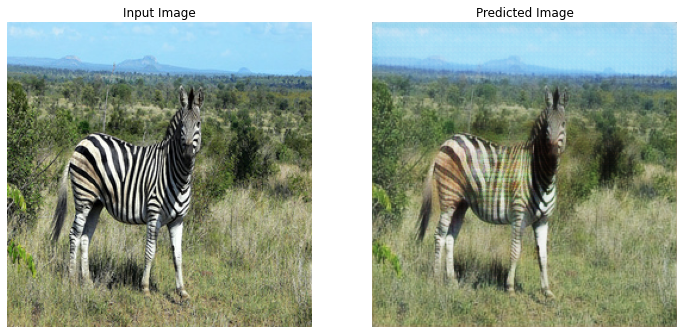

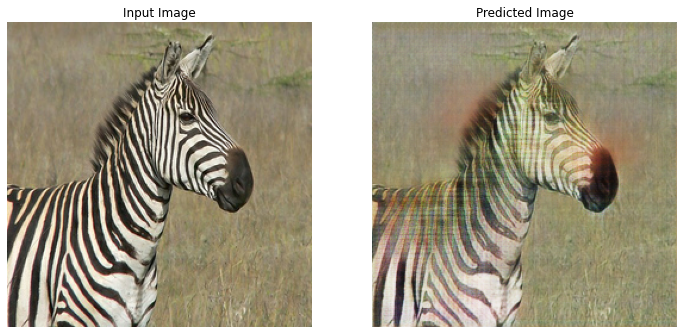

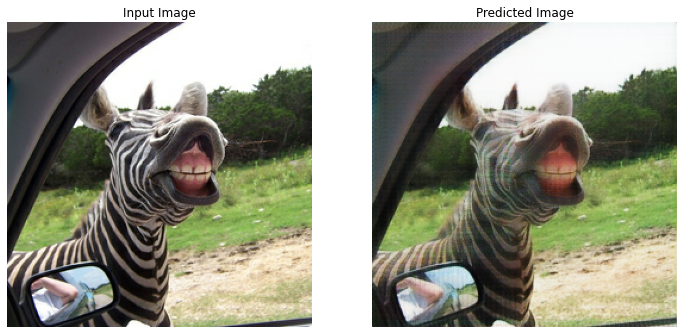

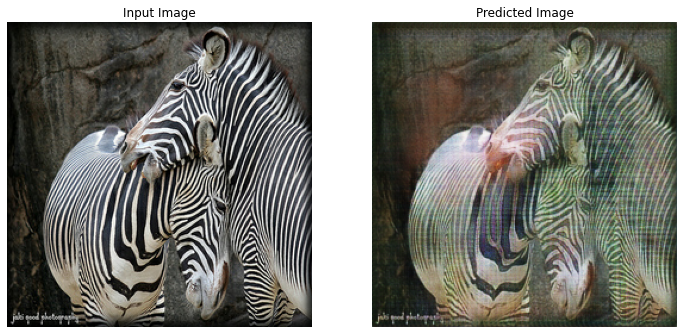

In [ ]:
# Run the trained model on the test dataset
for inp in test_zebras.take(5):
    generate_images(generator_to_horse, inp)

**Вывод:**<br>
Мною была проведена попыка обучить нейронную сеть CycleGAN на датасете horse2zebra превращать лошадей в зебр. Как видно после 20 эпох. нейросеть делает скромные попытки раскрашивания лошади в зебру. А вот обратный процесс, из зебры в лошадь, ей не даётся совсем.  
Возможно требуется большее количество эпох.